# Figure 1: CT feedback and behaviour modulates dLGN responses to movies

In [1]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
from utils import *

In [3]:
color_dict = get_color_dict(color_names=['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'yellow', 'lightblue'])

# Load data

Restrict to one experiment:

In [4]:
# Define experiment to plot
key = {'m': 'Ntsr1Cre_2019_0007', 's': 6, 'e': 9, 'u': 1}

In [5]:
# DF experiment
df_e = pd.read_csv('../data/data_raw.csv').applymap(decode_array)

Get data:

In [6]:
responses = np.vstack(df_e['responses'])
run = df_e['run'][0]
eye = df_e['eye'][0]
opto = df_e['opto'][0]

tv = df_e['tv'][0] # time vector

Plotting:

In [7]:
# Define plotting range
start_sec = 200
stop_sec = 900

trange = [np.where(tv>start_sec)[0][0], np.where(tv>stop_sec)[0][0]]

x_axis_dur = 50 # sec
xticks = np.arange(start_sec, stop_sec+1, x_axis_dur)

responses_plot = responses[:, trange[0]:trange[1]]
run_plot = run[trange[0]:trange[1]]
eye_plot = eye[trange[0]:trange[1]]
opto_plot = opto[trange[0]:trange[1]]

tv_plot = tv[trange[0]:trange[1]]
vmin_resp = 0
vmax_resp = 100

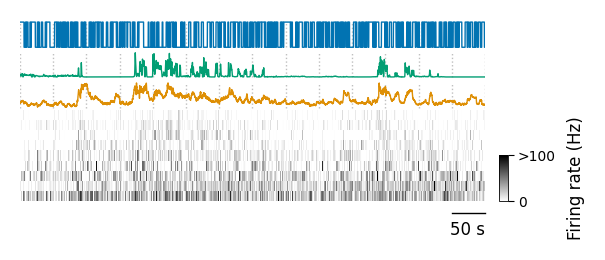

In [8]:
with plt.style.context("matplotlib_config.txt"):
    mosaic = """
    a
    b
    c
    d
    d
    d
    """
    fig, ax_dict = plt.subplot_mosaic(
        mosaic,
        figsize=(3, 1.2),
        dpi=200,
        constrained_layout=True,
    )

    txt_kwargs = dict(
        color="black", fontsize="larger"
    )
    
    
    
    # Opto
    ax = ax_dict['a']
    opto_plot = opto[trange[0]:trange[1]]
    ax.plot(tv_plot, opto_plot, color=color_dict['blue'])
    for xtick in xticks:
        ax.vlines(x=xtick, ymin=0, ymax=opto_plot.max(), color='gray', linestyle=':', alpha=.5)
    ax.set_xlim([tv_plot[0],tv_plot[-1]])
    ax.set_ylim([opto_plot.min()-.1, opto_plot.max()+.1])
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels([])

    # Running
    ax = ax_dict['b']
    run_plot = run[trange[0]:trange[1]]
    ax.plot(tv_plot, run_plot, color=color_dict['green'])
    for xtick in xticks:
        ax.vlines(x=xtick, ymin=0, ymax=run_plot.max(), color='gray', linestyle=':', alpha=.5)
    ax.set_xlim([tv_plot[0],tv_plot[-1]])
    ax.set_ylim([run_plot.min()-.1, run_plot.max()+.1])
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels([])

    # Eye
    ax = ax_dict['c']
    eye_plot = eye[trange[0]:trange[1]]
    ax.plot(tv_plot, eye_plot, color=color_dict['orange'])
    for xtick in xticks:
        ax.vlines(x=xtick, ymin=0, ymax=eye_plot.max(), color='gray', linestyle=':', alpha=.5)
    ax.set_xlim([tv_plot[0],tv_plot[-1]])
    ax.set_ylim([eye_plot.min()-.1, eye_plot.max()+.1])
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels([])

    # Responses
    X = responses_plot
    scaler = StandardScaler()
    X_standardized = scaler.fit_transform(X)

    # PCA
    pca = PCA(n_components=4)
    pca.fit(X_standardized)
    X_pca = pca.transform(X_standardized)

    # Sort by PC
    idxs_sorted = np.flip(np.argsort(X_pca[:,0]))
    responses_sorted = X[idxs_sorted[::-1]]

    ax = ax_dict['d']
    im = ax.imshow(responses_sorted, aspect='auto', cmap='gray_r', interpolation='none', vmin=vmin_resp, vmax=vmax_resp)
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.set_xlabel(f'{x_axis_dur} s', loc='right', labelpad=7)

    axins = inset_axes(
                    ax,
                    width="2%",  
                    height="50%",  
                    loc="center",
                    bbox_to_anchor=(.54, -0.25, 1, 1),
                    bbox_transform=ax.transAxes,
                    borderpad=0,
    )
    cbar = fig.colorbar(im, cax=axins, orientation='vertical', ticks=[vmin_resp, vmax_resp], label='Firing rate (Hz)')
    cbar.ax.tick_params(labelsize=5)
    cbar.set_ticklabels([vmin_resp, f'>{vmax_resp}'])

    sns.despine(bottom=True, left=True)
    plt.subplots_adjust(wspace=0, hspace=0)
    
    # x axis
    ax_dict['c'].spines['bottom'].set_visible(True)
    ax_dict['c'].spines['bottom'].set_bounds([stop_sec-x_axis_dur, stop_sec])
    ax_dict['c'].spines['bottom'].set_linewidth(.5)
    ax_dict['c'].spines['bottom'].set_position(('outward', 37))

In [9]:
f'number of neurons = {responses_sorted.shape[0]}'

'number of neurons = 9'

## Example opto unit

In [10]:
key = {'m': 'Ntsr1Cre_2019_0008', 's': 5, 'e': 8, 'u': 19}

In [11]:
df = pd.read_csv('../data/{:s}_s{:02d}_e{:02d}_u{:02d}.csv'.format(key['m'], key['s'], key['e'], key['u'])).applymap(decode_array)

In [12]:
midbins_ctrl = df['ctrl_midbins'].values[0]
rasters_ctrl = df['ctrl_rasters'].values[0]
psths_ctrl = df['ctrl_psths'].values[0]

midbins_opto = df['opto_midbins'].values[0]
rasters_opto = df['opto_rasters'].values[0]
psths_opto = df['opto_psths'].values[0]

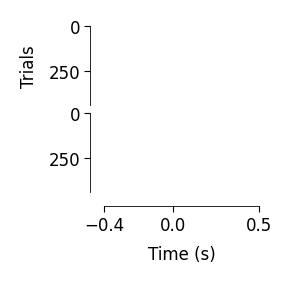

In [13]:
marker_type='|'
marker_size=.01
offsets=[np.round(midbins_opto[0], 1), -np.round(midbins_opto[-1], 1)]

psth_opto_mean = np.mean(psths_opto, axis=0)
psth_opto_err = scipy.stats.sem(psths_opto, axis=0)

psth_ctrl_mean = np.mean(psths_ctrl, axis=0)
psth_ctrl_err = scipy.stats.sem(psths_ctrl, axis=0)

with plt.style.context("matplotlib_config.txt"):
    mosaic = """
    a
    b
    """
    fig, ax_dict = plt.subplot_mosaic(
        mosaic,
        figsize=(1, 1.1),
        dpi=200,
        constrained_layout=True,
    )
    
    txt_kwargs = dict(
        color="black", fontsize="larger"
    )
    
    # Spike raster plot control trials
    ax = ax_dict['a']
    for i in range(len(rasters_ctrl)):
        y=np.ones((rasters_ctrl[i].shape[0],))*i
        ax.scatter(rasters_ctrl[i], y, c=color_dict['gray'], marker=marker_type, s=marker_size, alpha=1)
        ax.set_xlim([offsets[0], 1+offsets[1]])
        ax.set_ylim([0, rasters_ctrl.shape[0]])
        ax.set_xticks([])
        ax.set_xticklabels([])
        ax.invert_yaxis()
        ax.set_ylabel('Trials')
        
    # Spike raster plot opto trials
    ax = ax_dict['b']
    for i in range(len(rasters_opto)):
        y=np.ones((rasters_opto[i].shape[0],))*i
        ax.scatter(rasters_opto[i], y, c=color_dict['blue'], marker=marker_type, s=marker_size, alpha=1)
    ax.set_ylim([0, rasters_opto.shape[0]])
    ax.invert_yaxis()
    ax.set_xlim([offsets[0], 1+offsets[1]])
    ax.set_xticks([offsets[0], 0, 1+offsets[1]])
    ax.set_xlabel('Time (s)')

    
    # Formatting
    sns.despine(offset=5, trim=False)
    ax_dict['a'].spines['bottom'].set_visible(False)
    #ax_dict['b'].spines['bottom'].set_visible(False)
    
    plt.subplots_adjust(hspace=0.1)

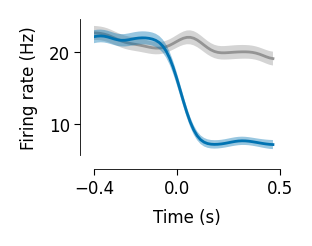

In [14]:
marker_type='|'
marker_size=.01
offsets=[np.round(midbins_opto[0], 1), -np.round(midbins_opto[-1], 1)]

psth_opto_mean = np.mean(psths_opto, axis=0)
psth_opto_err = scipy.stats.sem(psths_opto, axis=0)

psth_ctrl_mean = np.mean(psths_ctrl, axis=0)
psth_ctrl_err = scipy.stats.sem(psths_ctrl, axis=0)

with plt.style.context("matplotlib_config.txt"):
    mosaic = """
    a
    """
    fig, ax_dict = plt.subplot_mosaic(
        mosaic,
        figsize=(1.2, .9),
        dpi=200,
        constrained_layout=True,
    )
    
    txt_kwargs = dict(
        color="black", fontsize="larger"
    )
        
    # PSTH
    ax = ax_dict['a']
    ax.plot(midbins_ctrl, psth_ctrl_mean, 
            c=color_dict['gray'], 
            lw=1,
            zorder=1, 
            label='Control')
    ax.fill_between(midbins_ctrl, psth_ctrl_mean-psth_ctrl_err, psth_ctrl_mean+psth_ctrl_err,
                    fc=color_dict['gray'], 
                    ec="none", 
                    alpha=0.4,
                    zorder=1)
    ax.plot(midbins_opto, psth_opto_mean, 
            c=color_dict['blue'], 
            lw=1,
            zorder=2, 
            label='CT FB supp')
    ax.fill_between(midbins_opto, psth_opto_mean-psth_opto_err, psth_opto_mean+psth_opto_err,
                    fc=color_dict['blue'], 
                    ec="none", 
                    alpha=0.4,
                    zorder=2)
    ax.set_xlim([offsets[0], 1+offsets[1]])
    ax.set_xticks([offsets[0], 0, 1+offsets[1]])
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Firing rate (Hz)')

    sns.despine(offset=5, trim=False)
    
    plt.subplots_adjust(hspace=0.1)

# Firing rate scatters

In [15]:
# Mark example neuron
key = {'m': 'Ntsr1Cre_2019_0008', 's': 5, 'e': 8, 'u': 19}

Load data:

In [16]:
filename = '../data/population_data.csv'
df = pd.read_csv(filename)

## CT FB suppression

p = 1.24E-02
12.26 vs. 11.50 spikes per sec


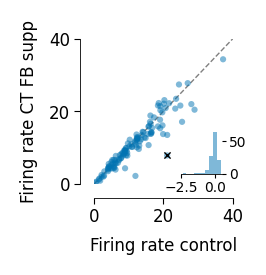

In [17]:
fr_ctrl = df['fr_ctrl']
fr_opto = df['fr_opto']
idx_exmpl_neuron = np.where((df['m']==key['m']) & (df['s']==key['s']) & (df['e']==key['e']) & (df['u']==key['u']) )[0][0]

fig, ax_dict = plot_fr_scatter(x=fr_ctrl, 
                               y=fr_opto, 
                               labels=['Firing rate control', 'Firing rate CT FB supp'], 
                               facecolor=color_dict['blue'], 
                               axlims=[0,40], 
                               figsize=(1.2, 1.2),
                               plot_pval=False,
                               mark_neurons=[idx_exmpl_neuron])

p = 1.24E-02
12.26 vs. 11.50 spikes per sec


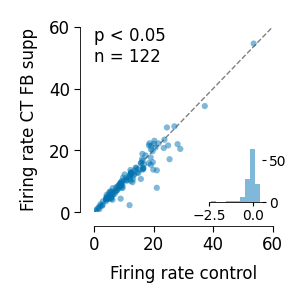

In [18]:
fr_ctrl = df['fr_ctrl']
fr_opto = df['fr_opto']

fig, ax_dict = plot_fr_scatter(x=fr_ctrl, 
                               y=fr_opto, 
                               labels=['Firing rate control', 'Firing rate CT FB supp'], 
                               facecolor=color_dict['blue'], 
                               axlims=[0,60], 
                               figsize=(1.4, 1.4),
                              )

## Running

p = 8.31E-16
11.02 vs. 12.87 spikes per sec


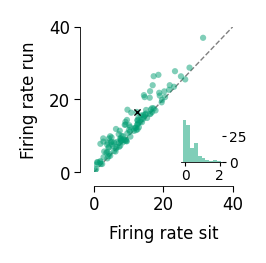

In [19]:
fr_run = df['fr_run']
fr_sit = df['fr_sit']

fig, ax_dict = plot_fr_scatter(x=fr_sit, 
                               y=fr_run, 
                               labels=['Firing rate sit', 'Firing rate run'], 
                               facecolor=color_dict['green'], 
                               axlims=[0,40], 
                               figsize=(1.2, 1.2),
                               plot_pval=False,
                               mark_neurons=[idx_exmpl_neuron])

p = 8.31E-16
11.02 vs. 12.87 spikes per sec


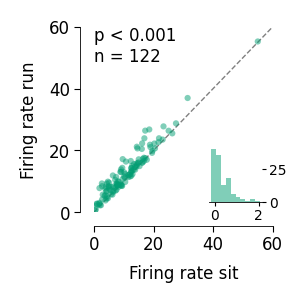

In [20]:
fr_run = df['fr_run']
fr_sit = df['fr_sit']

fig, ax_dict = plot_fr_scatter(x=fr_sit, 
                               y=fr_run, 
                               labels=['Firing rate sit', 'Firing rate run'], 
                               facecolor=color_dict['green'], 
                               axlims=[0,60], 
                               figsize=(1.4, 1.4))

## Pupil size 

p = 4.98E-07
11.03 vs. 13.00 spikes per sec


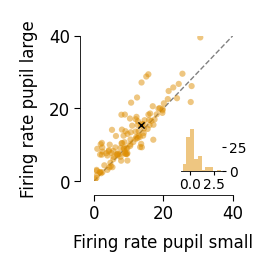

In [21]:
pupil_large = df['fr_pupil_large']
pupil_small = df['fr_pupil_small']

fig, ax_dict = plot_fr_scatter(x=pupil_small, 
                               y=pupil_large, 
                               labels=['Firing rate pupil small', 'Firing rate pupil large'], 
                               facecolor=color_dict['orange'], 
                               axlims=[0,40], 
                               figsize=(1.2, 1.2),
                               plot_pval=False,
                               mark_neurons=[idx_exmpl_neuron])

p = 4.98E-07
11.03 vs. 13.00 spikes per sec


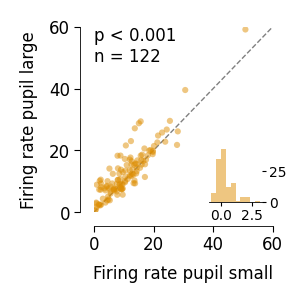

In [22]:
pupil_large = df['fr_pupil_large']
pupil_small = df['fr_pupil_small']

fig, ax_dict = plot_fr_scatter(x=pupil_small, 
                               y=pupil_large, 
                               labels=['Firing rate pupil small', 'Firing rate pupil large'], 
                               facecolor=color_dict['orange'], 
                               axlims=[0,60], 
                               figsize=(1.4, 1.4))